@dataset{
    dataset,
    author = {Timilsina, Bimal},
    year = {2021},
    month = {08},
    pages = {},
    title = {News Article Category Dataset},
}

In [1]:
import pandas as pd

In [2]:
df = pd.read_json('../input/news-category-dataset/News_Category_Dataset_v3.json', lines=True)

In [3]:
df['category'] = df['category'].astype('category')

In [4]:
from sklearn.model_selection import train_test_split

x = df.drop('category', axis=1)
y = df['category']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

def identity_tokenizer(t):
    return t

model = make_pipeline(TfidfVectorizer(stop_words="english", lowercase=True), MultinomialNB())

model.fit(x_train['headline'], y_train)


Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(stop_words='english')),
                ('multinomialnb', MultinomialNB())])

In [7]:
labels = model.predict(x_test['headline'])

In [8]:
display(y_test)
display(labels)

164032     WELLNESS
161397     WELLNESS
28662     EDUCATION
134043     WELLNESS
161368       TRAVEL
            ...    
136818    PARENTING
30823         MEDIA
125747     POLITICS
46268        SPORTS
191151    PARENTING
Name: category, Length: 41906, dtype: category
Categories (42, object): ['ARTS', 'ARTS & CULTURE', 'BLACK VOICES', 'BUSINESS', ..., 'WELLNESS', 'WOMEN', 'WORLD NEWS', 'WORLDPOST']

array(['WELLNESS', 'WELLNESS', 'POLITICS', ..., 'POLITICS', 'POLITICS',
       'STYLE & BEAUTY'], shape=(41906,), dtype='<U14')

In [9]:
from sklearn.metrics import confusion_matrix, f1_score

category_names = pd.unique(y_train).sort_values()
mat = confusion_matrix(y_test, labels, labels=category_names)
f1_score_result = f1_score(y_test, labels, average='micro')

0.41908079988545793
[[ 0  0  0 ...  0  0  0]
 [ 0  0  1 ...  1  0  0]
 [ 0  0  7 ...  0  0  0]
 ...
 [ 0  0  0 ... 22  0  0]
 [ 0  0  0 ...  0 13  0]
 [ 0  0  0 ...  0  0  1]]


Text(162.5, 0.5, 'predicted label')

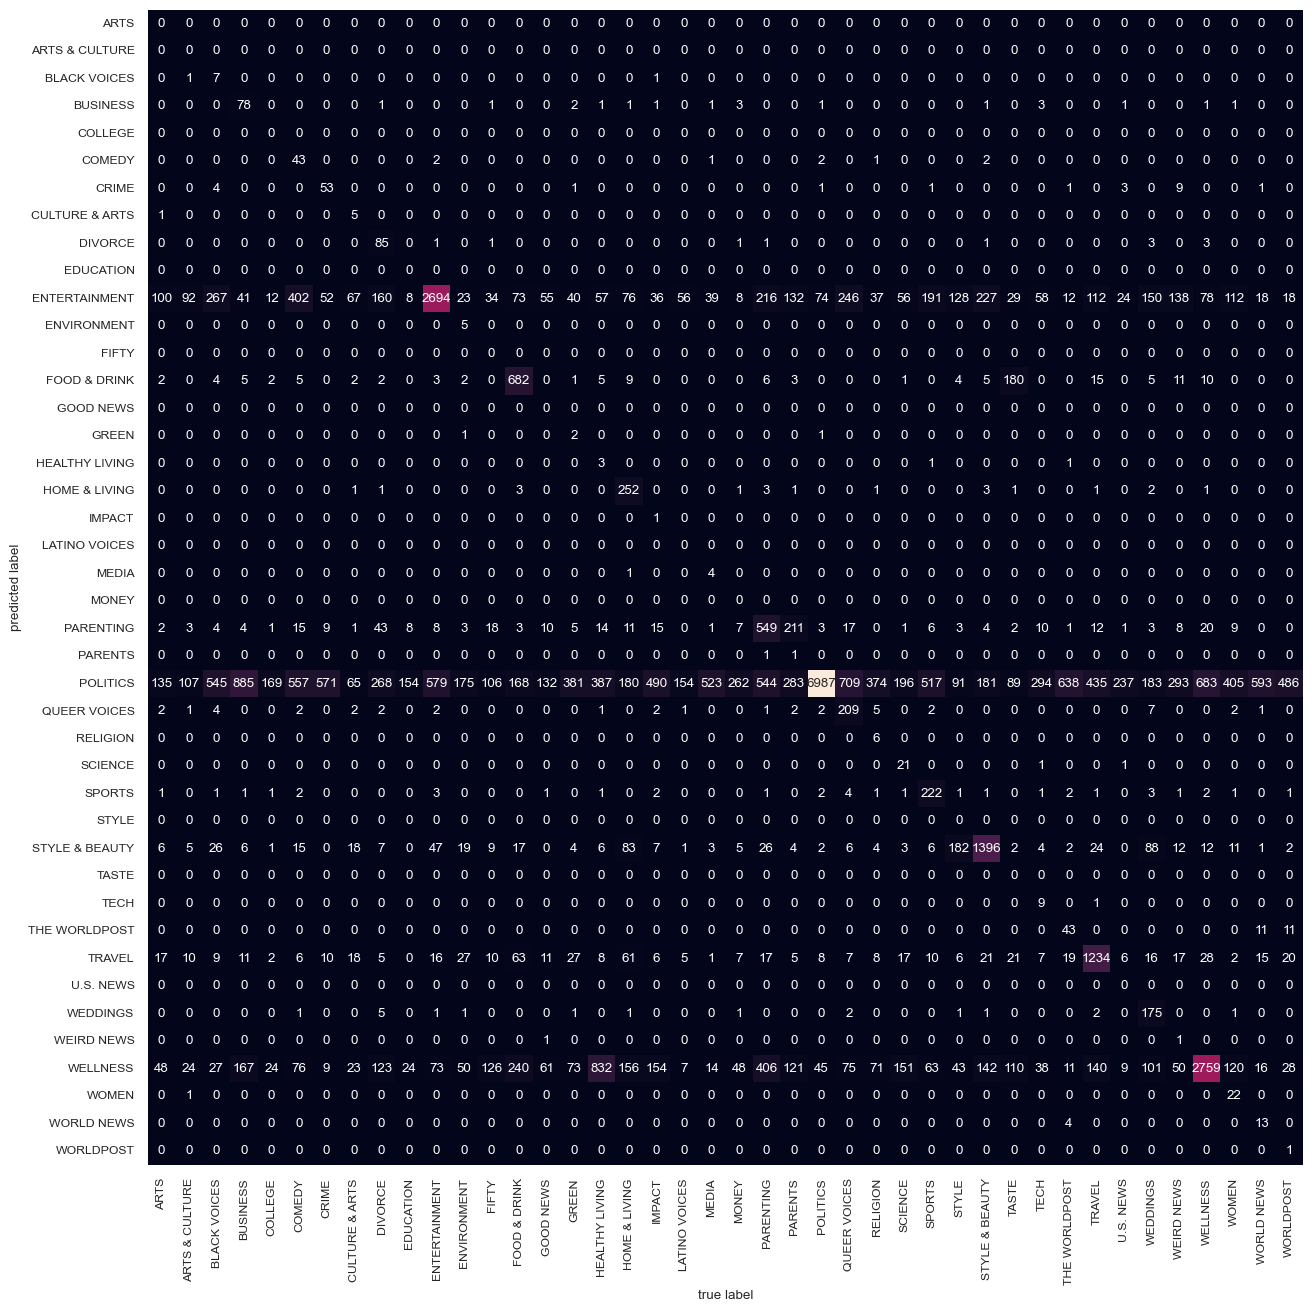

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

print(f1_score_result)

print(mat)

plt.rcParams.update({'font.size': 8, 'figure.figsize': [15, 15]})
sns.set(font_scale=0.8)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=category_names, yticklabels=category_names)
plt.xlabel('true label')
plt.ylabel('predicted label')